#**Analysis of Key Features for Predicting Number of Children**

####**By: Ayda Nayeb Nazar and Matthew Lacayo**

In this project, our goal was to find the most important features for predicting the number of children an Indonesian woman from 1987 had, and to explore various models to help us achieve the prediction task. The types of models used include lasso, linear regression, k-nearest neighbors, decision trees, and random forests. Feature engineering showed that standard of living had little correlation with the number of children a woman has. We compared various versions of these models against each other with cross validation to make our final selection.

In [1]:
import pandas as pd
import sklearn
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import RidgeClassifierCV
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from sklearn.linear_model import LogisticRegressionCV
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import log_loss
from sklearn.metrics import make_scorer
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
import seaborn as sns
from matplotlib import pyplot as plt

DATA_URL = 'https://raw.githubusercontent.com/aydanazar/Data-Science-Projects/master/Contraceptive%20Data%20Analysis/data/contraceptive_for_students.csv'

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Let's begin by taking a look at the data set

In [2]:
df = pd.read_csv(DATA_URL)
original = df.copy()
df.head()

,wife_age,wife_education,husband_education,num_child,wife_religion,wife_work,husband_occupation,standard_living,media_exposure,contraceptive
0,24,2,3,3,1,1,2,3,0,1
1,45,1,3,10,1,1,3,4,0,1
2,43,2,3,7,1,1,3,4,0,1
3,42,3,2,9,1,1,3,3,0,1
4,36,3,3,8,1,1,3,2,0,1


In [ ]:
df.shape

(1473, 10)

Since every column besides age and num_child is categorical, we will store these in a list so that we can later onehot encode the categorical columns. Then, we will convert the categorical variables from their current numerical form into a string form that is easier to interpret. In order to work with this data, we will later onehot encode categorical variables inside a pipeline.


In [ ]:
quantitative_columns = ['wife_age', 'num_child']
categorical_columns = ['wife_education', 'husband_education', 'wife_religion', 
                       'wife_work', 'husband_occupation', 'standard_living', 
                       'media_exposure', 'contraceptive']
df['contraceptive'] = df['contraceptive'].map({1:'None', 2:'ST', 3:'LT'})
df['wife_education'] = df['wife_education'].map({1:'Low', 2:'Low-Medium', 3:'Medium-High', 4:"High"})
df['husband_education'] = df['husband_education'].map({1:'Low', 2:'Low-Medium', 3:'Medium-High', 4:"High"})
df['wife_religion'] = df['wife_religion'].map({0:'Non Islam', 1:'Islam'})
df['wife_work'] = df['wife_work'].map({0:'Yes', 1:'No'})
df['husband_occupation'] = df['husband_occupation'].map({1:'Professional/Technical/Clerical', 
                                                         2:'Sales/Services',
                                                         3:"Manual",
                                                         4: "Agriculture"})
df['standard_living'] = df['standard_living'].map({1:'Low', 2:'Low-Medium', 3:'Medium-High', 4:"High"})
df['media_exposure'] = df['media_exposure'].map({0:'Good', 1:'Not Good'})
df.head()

,wife_age,wife_education,husband_education,num_child,wife_religion,wife_work,husband_occupation,standard_living,media_exposure,contraceptive
0,24,Low-Medium,Medium-High,3,Islam,No,Sales/Services,Medium-High,Good,None
1,45,Low,Medium-High,10,Islam,No,Manual,High,Good,None
2,43,Low-Medium,Medium-High,7,Islam,No,Manual,High,Good,None
3,42,Medium-High,Low-Medium,9,Islam,No,Manual,Medium-High,Good,None
4,36,Medium-High,Medium-High,8,Islam,No,Manual,Low-Medium,Good,None


To get a rough idea of how each feature correlates with the number of children a wife has, we can view the following boxplots:

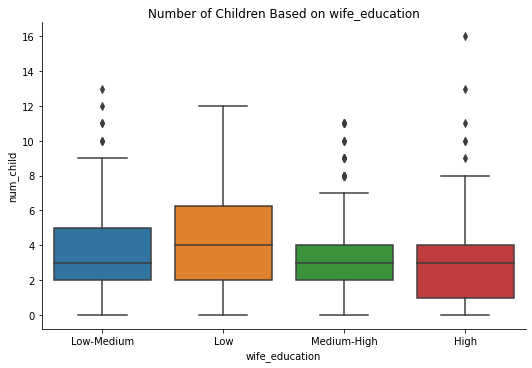

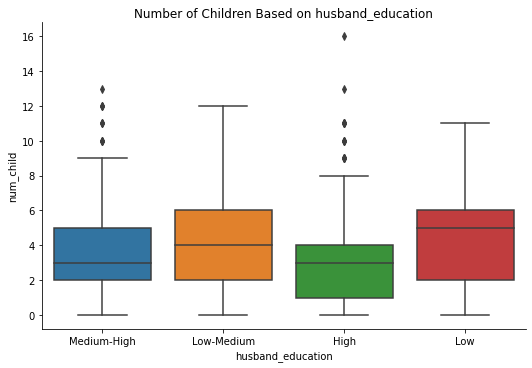

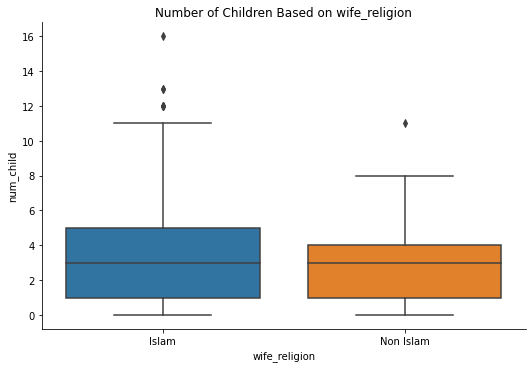

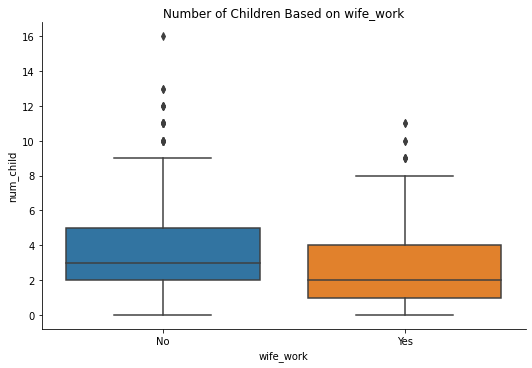

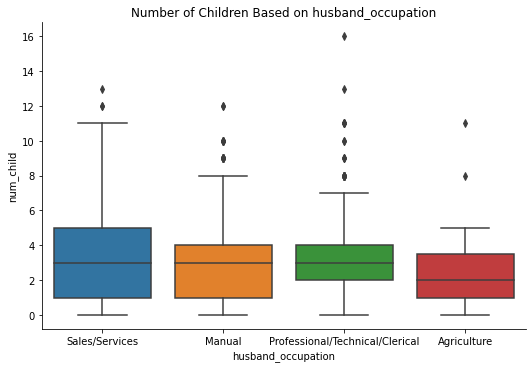

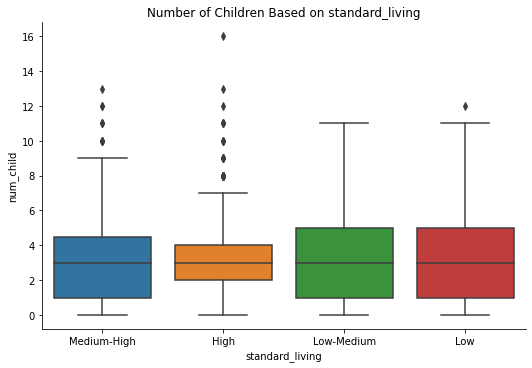

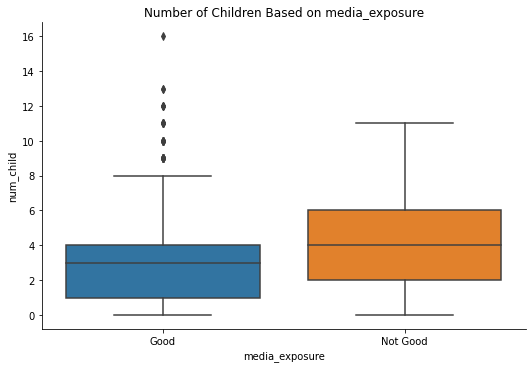

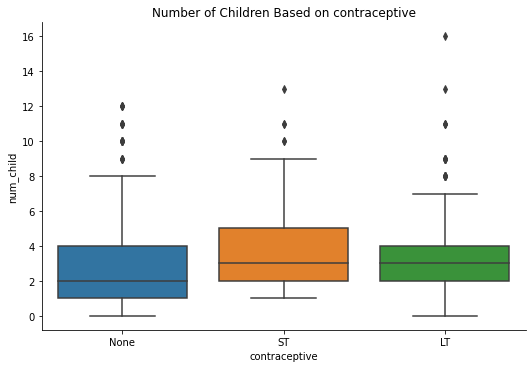

In [ ]:
for column in categorical_columns:
    sns.catplot(x=column, y="num_child", data=df, kind='box', height=5, aspect=1.5)
    plt.title("Number of Children Based on " + column)
    plt.show()

Since our goal is to classify the type of contraceptive, we will make some plots to see the correlation between various features and the type of contraceptive. We begin by exploring the relationship between the age of the woman, and the number of kids she has. 

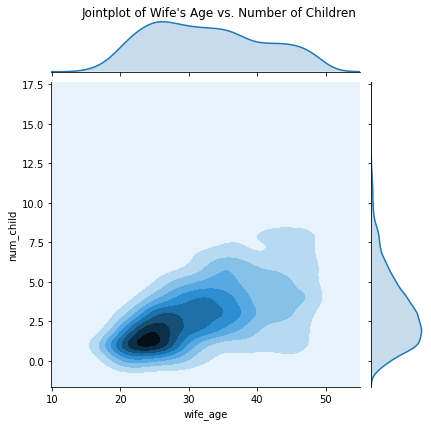

In [ ]:
ax = sns.jointplot(x="wife_age",y="num_child", kind='kde', data=df)
ax.fig.suptitle("Jointplot of Wife's Age vs. Number of Children")
ax.fig.subplots_adjust(top=0.95)

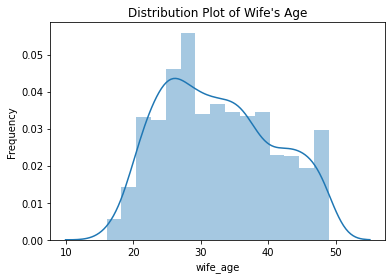

In [ ]:
sns.distplot(df['wife_age'])
plt.title("Distribution Plot of Wife's Age")
plt.ylabel("Frequency");

We can even try looking at a heatmap to get an idea of what features may be most helpful in our model. In this case, we want all features to be treated numerically, so we will use the original data frame.

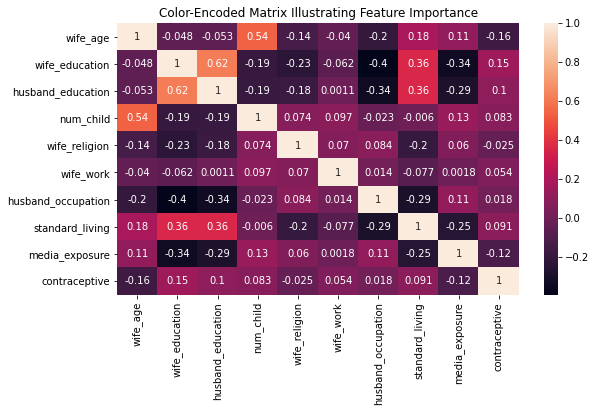

In [ ]:
corr_df = original
plt.figure(figsize=(9,5))
sns.heatmap(corr_df.corr(), annot=True)
plt.title("Color-Encoded Matrix Illustrating Feature Importance");

By looking at the fourth row from the top, we can see the magnitude of correlation between the features in the X-axis, and the number of children. We can see that standard_living has a very small correlation, so we may want to consider making a model without that feature. We will continue to explore this in subsequent analysis below.

Now, we will split our data into training and testing with a 80% split.

In [ ]:
train_data, test_data = train_test_split(df, test_size=0.2, random_state=2718)

We also want to keep track of all the models we make, so we will use the following dictionary throughout the notebook to store various models

In [ ]:
models = {}

The first model we make will be a Lasso model, which an hopefully give us some insight into the most important features by inspecting the coefficients. We create our pipeline below (using mean absolute error as our scoring function) and inspect the coefficients. 

In [ ]:
categorical_columns_to_use = categorical_columns
quantitative_columns_to_use = ['wife_age']
model = Pipeline([
          ("SelectColumns", 
                  ColumnTransformer([("select_categorical", OneHotEncoder(), categorical_columns_to_use),
                                      ("select_quantitative", StandardScaler(), quantitative_columns_to_use)
                  ])),
          ("LassoCV", RidgeCV(cv=5))        
])

model.fit(train_data, train_data['num_child'])
cross_val_score(model, train_data, train_data['num_child'], scoring=make_scorer(mean_absolute_error)).mean()

1.3809828151299943

In [ ]:
mean_absolute_error(train_data['num_child'], model.predict(train_data))

1.3535637920949066

In [ ]:
model["LassoCV"].coef_

array([-0.49199164, -0.02527383,  0.37398496,  0.14328051, -0.23362715,
        0.08853855,  0.22345289, -0.0783643 ,  0.37487593, -0.37487593,
        0.21123819, -0.21123819, -0.29437519,  0.10904214, -0.0604183 ,
        0.24575135, -0.1203753 ,  0.04216296,  0.01149155,  0.06672079,
       -0.11066179,  0.11066179,  0.31602208, -0.68768558,  0.3716635 ,
        1.41463075])

Consistent with our analysis above, we find that the magnitude of the coefficients corresponding with standard living are relatively small.

We will save our model in the dictionary below.

In [ ]:
models["LassoCV"] = model

We start by making a baseline model to compare to: a linear regression model with all features included.

In [ ]:
categorical_columns_to_use = categorical_columns
quantitative_columns_to_use = ['wife_age']
model = Pipeline([
          ("SelectColumns", 
                  ColumnTransformer([("select_categorical", OneHotEncoder(), categorical_columns_to_use),
                                      ("select_quantitative", StandardScaler(), quantitative_columns_to_use)
                  ])),
          ("LinearRegression", LinearRegression())        
])

model.fit(train_data, train_data['num_child'])
cross_val_score(model, train_data, train_data['num_child'], scoring=make_scorer(mean_absolute_error)).mean()

1.3895706928416878

In [ ]:
mean_absolute_error(train_data['num_child'], model.predict(train_data))

1.3624464465725807

In [ ]:
models["LinearRegression"] = model

Next, we will remove the standard_living feature, since our prior analysis showed it may not be very helpful in our task of predicting the number of children

In [ ]:
categorical_columns_to_use = ['wife_education', 'husband_education', 'wife_religion', 
                       'wife_work', 'husband_occupation', 
                       'media_exposure', 'contraceptive']
quantitative_columns_to_use = ['wife_age']
model = Pipeline([
          ("SelectColumns", 
                  ColumnTransformer([("select_categorical", OneHotEncoder(), categorical_columns_to_use),
                                      ("select_quantitative", StandardScaler(), quantitative_columns_to_use)
                  ])),
          ("LinearRegression", LinearRegression())        
])

model.fit(train_data, train_data['num_child'])
cross_val_score(model, train_data, train_data['num_child'], scoring=make_scorer(mean_absolute_error)).mean()

1.3813585523350163

In [ ]:
mean_absolute_error(train_data['num_child'], model.predict(train_data))

1.362465513582343

In [ ]:
models["LR-no-SL"] = model

Sure enough, we achieved a lower cross validation score. The next feature with the smallest correlation to number of children is husband occupation, so we will try removing it.

In [ ]:
categorical_columns_to_use = ['wife_education', 'husband_education', 'wife_religion', 
                       'wife_work', 'media_exposure', 'contraceptive']
quantitative_columns_to_use = ['wife_age']
model = Pipeline([
          ("SelectColumns", 
                  ColumnTransformer([("select_categorical", OneHotEncoder(), categorical_columns_to_use),
                                      ("select_quantitative", StandardScaler(), quantitative_columns_to_use)
                  ])),
          ("LinearRegression", LinearRegression())        
])

model.fit(train_data, train_data['num_child'])
cross_val_score(model, train_data, train_data['num_child'], scoring=make_scorer(mean_absolute_error)).mean()

1.3861057536540975

In [ ]:
mean_absolute_error(train_data['num_child'], model.predict(train_data))

1.3659837913837012

In [ ]:
models['LR-no-SL-no-HO'] = model

Finally, we can also try removing wife_religion since it has the next smallest correlation.

In [ ]:
categorical_columns_to_use = ['wife_education', 'husband_education', 
                       'wife_work', 'media_exposure', 
                       'contraceptive']
quantitative_columns_to_use = ['wife_age']
model = Pipeline([
          ("SelectColumns", 
                  ColumnTransformer([("select_categorical", OneHotEncoder(), categorical_columns_to_use),
                                      ("select_quantitative", StandardScaler(), quantitative_columns_to_use)
                  ])),
          ("LinearRegression", LinearRegression())        
])

model.fit(train_data, train_data['num_child'])
cross_val_score(model, train_data, train_data['num_child'], scoring=make_scorer(mean_absolute_error)).mean()

1.3948187319689869

In [ ]:
mean_absolute_error(train_data['num_child'], model.predict(train_data))

1.3753581281833616

In [ ]:
models['LR-no-SL-no-HO-no-WR'] = model

Our best LR model was the one where we only removed standard_living. Of all our models, the LassoCV model performed best in terms of cross validation score. Now, we will make 3 more models: a K-nearest-neighbors model, a decision tree, and a random forest. All of these will be made without the standard living feature.

We start with the KNN classifier. We can use cross validation to pick the best value of k. We will iterate over the values between 1 and 50, and pick the k value that minimized the CV score.

In [ ]:
categorical_columns_to_use = ['wife_education', 'husband_education', 'wife_religion', 
                       'wife_work', 'media_exposure', 'contraceptive',
                       'husband_occupation']
quantitative_columns_to_use = ['wife_age']
scores = []
for k in range(1, 51, 1):
  model = Pipeline([
            ("SelectColumns", 
                    ColumnTransformer([("select_categorical", OneHotEncoder(), categorical_columns_to_use),
                                        ("select_quantitative", StandardScaler(), quantitative_columns_to_use)
                    ])),
            ("KNearestNeighbors", KNeighborsRegressor(n_neighbors=k))        
  ])
  model.fit(train_data, train_data['num_child'])
  cv_score = cross_val_score(model, train_data, train_data['num_child'], scoring=make_scorer(mean_absolute_error)).mean()
  scores.append(cv_score)
best_k = np.argmin(scores) + 1
model = Pipeline([
            ("SelectColumns", 
                    ColumnTransformer([("select_categorical", OneHotEncoder(), categorical_columns_to_use),
                                        ("select_quantitative", StandardScaler(), quantitative_columns_to_use)
                    ])),
            ("KNearestNeighbors", KNeighborsRegressor(n_neighbors=best_k))        
  ])
model.fit(train_data, train_data['num_child'])
cross_val_score(model, train_data, train_data['num_child'], scoring=make_scorer(mean_absolute_error)).mean()

1.42399370553716

In [ ]:
mean_absolute_error(train_data['num_child'], model.predict(train_data))

1.3916885321808923

In [ ]:
models["KNN-no-SL"] = model

Now we can try a decision tree. We will tune the max_depth hyperparameter similarly to how we did it above.

In [ ]:
categorical_columns_to_use = ['wife_education', 'husband_education', 'wife_religion', 
                       'wife_work', 'media_exposure', 'contraceptive',
                       'husband_occupation']
quantitative_columns_to_use = ['wife_age']
scores = []
for k in range(1, 21, 1):
  model = Pipeline([
            ("SelectColumns", 
                    ColumnTransformer([("select_categorical", OneHotEncoder(), categorical_columns_to_use),
                                        ("select_quantitative", StandardScaler(), quantitative_columns_to_use)
                    ])),
            ("DecisionTree", DecisionTreeRegressor(max_depth=k, random_state=314))        
  ])
  model.fit(train_data, train_data['num_child'])
  cv_score = cross_val_score(model, train_data, train_data['num_child'], scoring=make_scorer(mean_absolute_error)).mean()
  scores.append(cv_score)
best_k = np.argmin(scores) + 1
model = Pipeline([
            ("SelectColumns", 
                    ColumnTransformer([("select_categorical", OneHotEncoder(), categorical_columns_to_use),
                                        ("select_quantitative", StandardScaler(), quantitative_columns_to_use)
                    ])),
            ("DecisionTree", DecisionTreeRegressor(max_depth=best_k, random_state=314))        
  ])
model.fit(train_data, train_data['num_child'])
cross_val_score(model, train_data, train_data['num_child'], scoring=make_scorer(mean_absolute_error)).mean()

1.4414357318116537

In [ ]:
mean_absolute_error(train_data['num_child'], model.predict(train_data))

1.3198331696297525

In [ ]:
models["DecisionTree-no-SL"] = model

Lastly, we will train a random forest model below, tuning the n_estimators hyperparameter with cross validation. We will also set the max_depth hyperparameter to the value we found for the decision tree.

In [ ]:
categorical_columns_to_use = ['wife_education', 'husband_education', 'wife_religion', 
                       'wife_work', 'media_exposure', 'contraceptive',
                       'husband_occupation']
quantitative_columns_to_use = ['wife_age']
scores = []
for n in range(1, 101, 1):
  model = Pipeline([
            ("SelectColumns", 
                    ColumnTransformer([("select_categorical", OneHotEncoder(), categorical_columns_to_use),
                                        ("select_quantitative", StandardScaler(), quantitative_columns_to_use)
                    ])),
            ("RandomForest", RandomForestRegressor(n_estimators=n, max_depth=best_k, random_state=314))        
  ])
  model.fit(train_data, train_data['num_child'])
  cv_score = cross_val_score(model, train_data, train_data['num_child'], scoring=make_scorer(mean_absolute_error)).mean()
  scores.append(cv_score)
best_n = np.argmin(scores) + 1
model = Pipeline([
            ("SelectColumns", 
                    ColumnTransformer([("select_categorical", OneHotEncoder(), categorical_columns_to_use),
                                        ("select_quantitative", StandardScaler(), quantitative_columns_to_use)
                    ])),
            ("RandomForest", RandomForestRegressor(n_estimators=best_n, max_depth=best_k, random_state=314))        
  ])
model.fit(train_data, train_data['num_child'])
cross_val_score(model, train_data, train_data['num_child'], scoring=make_scorer(mean_absolute_error)).mean()

1.3709468884835065

In [ ]:
mean_absolute_error(train_data['num_child'], model.predict(train_data))

1.2439053841719618

In [ ]:
models["RandomForest-no-SL"] = model

Sure enough, this random forest model ended up having the lowest cross validation score. We will now evaluate our final model on the testing set.

In [ ]:
model = models["RandomForest-no-SL"]
mean_absolute_error(test_data['num_child'], model.predict(test_data))

1.3668842837321524

Our testing error ended up being slightly lower than our estimate from the CV score, but still very close to it. The average distance of our predictions from their true value was about 1.367 units on the testing set.

Finally, we can visualize the scores for all of our models on the graph below.

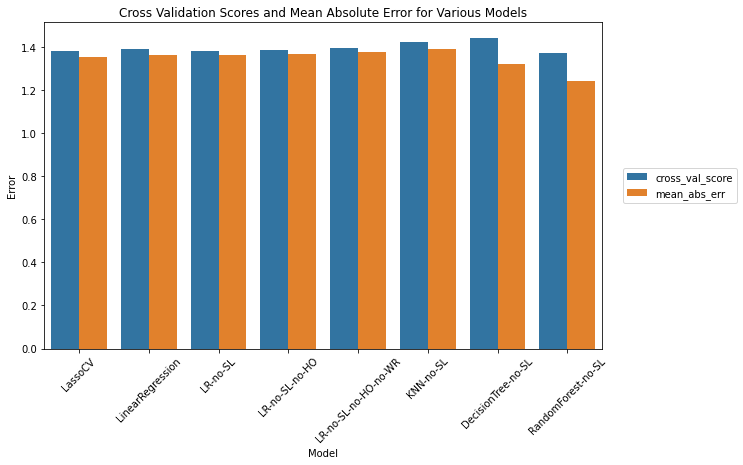

In [ ]:
models_w_errs = {"model": [], "cross_val_score": [], "mean_abs_err": []}
for name, model in models.items():
  models_w_errs['model'].append(name)
  models_w_errs["cross_val_score"].append(cross_val_score(model, train_data, train_data['num_child'], scoring=make_scorer(mean_absolute_error)).mean())
  models_w_errs["mean_abs_err"].append(mean_absolute_error(train_data['num_child'], model.predict(train_data)))
models_df = pd.DataFrame(models_w_errs)
tidy = models_df.melt(id_vars='model').rename(columns=str.title)
plt.figure(figsize=(10,6))
ax = sns.barplot(x="Model", y="Value", hue="Variable", data=tidy)
ax.set_ylabel("Error")
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
ax.legend(loc='center right', bbox_to_anchor=(1.25, 0.5), ncol=1)
plt.title("Cross Validation Scores and Mean Absolute Error for Various Models");